In [17]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context(context='paper')

%matplotlib inline

from census import Census
from us import states
from shapely.geometry import Point

In [18]:
c = Census("7deb96b03ae11f23a2fb544839ee195ccd646ac3")

In [19]:
at_road1 = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2023/ROADS/tl_2023_13063_roads.zip")
at_road2 = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2023/ROADS/tl_2023_13067_roads.zip")
at_road3 = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2023/ROADS/tl_2023_13089_roads.zip")
at_road4 = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2023/ROADS/tl_2023_13097_roads.zip")
at_road5 = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2023/ROADS/tl_2023_13113_roads.zip")
at_road6 = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2023/ROADS/tl_2023_13121_roads.zip")
at_road7 = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2023/ROADS/tl_2023_13135_roads.zip")
at_road8 = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2023/ROADS/tl_2023_13247_roads.zip")

## Let's see how it's useful

### I think its not bad!

In [20]:
#at_road1.explore()

## Concat Data

In [21]:
at_road_combined = gpd.GeoDataFrame(pd.concat([at_road1, at_road2, at_road3, at_road4, at_road5, at_road6, at_road7, at_road8], ignore_index=True))

In [22]:
at_road_combined = at_road_combined.to_crs(epsg='4326')

## Check if the road data can cover all bus stops

### Data is quite heavy but anyway it covers all bus stops!

In [23]:
stops_df = pd.read_csv('Transit_Stops/transit_stop_gtfs/stops.txt')
stops_gdf = gpd.GeoDataFrame(stops_df, geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat), crs="EPSG: 4326")

<Axes: >

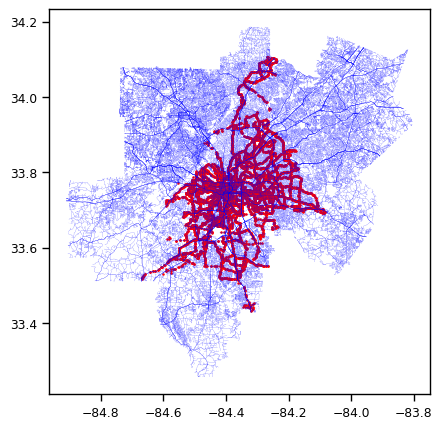

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))
at_road_combined.plot(ax=ax, color='blue', linewidth=0.1)
stops_gdf.plot(ax=ax, color='red', markersize=1)

In [25]:
#m = at_road_combined.explore(color='blue', linewidth=0.1)
#stops_gdf.explore(m=m, color='red', marker_kwds={'radius': 2})

#m

### Convex Hull -> Lets cut out roads won't be used

In [26]:
stops_gdf = stops_gdf.to_crs(epsg=3857)
convex_hull_polygon = stops_gdf.unary_union.convex_hull

Just in case, lets offset polygon to make bigger boundary

In [27]:
convex_hull_offset_polygon = convex_hull_polygon.buffer(300)
convex_hull_offset_gdf = gpd.GeoDataFrame(geometry=[convex_hull_offset_polygon])

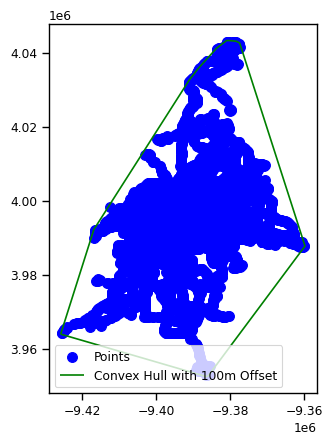

In [28]:
ax = stops_gdf.plot(color='blue', marker='o', markersize=50, label='Points')
convex_hull_offset_gdf.boundary.plot(ax=ax, color='green', label='Convex Hull with 100m Offset')
ax.legend()

Then, I'd like to cut out rest of area

<Axes: >

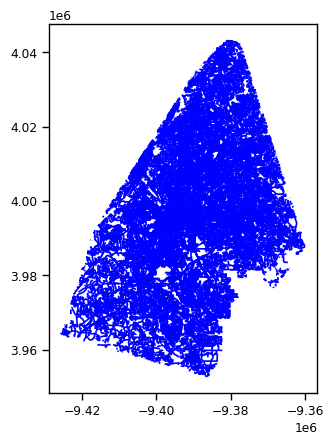

In [29]:
at_road_combined = at_road_combined.to_crs(epsg=3857)
roads_within_polygon = at_road_combined[at_road_combined.geometry.within(convex_hull_offset_polygon)]
roads_within_polygon.plot(color='blue', label='Roads within Convex Hull Offset')

In [30]:
road_cleaned = roads_within_polygon.to_crs(epsg=4326)
roads_within_polygon.to_file('roads_within_polygon2.shp')

In [64]:
road_cleaned

,LINEARID,FULLNAME,RTTYP,MTFCC,geometry
0,1104485402227,State Rte 138 Spr,S,S1200,"LINESTRING (-84.35442 33.52979, -84.35680 33.5..."
1,1103775664930,Lee St Con,M,S1400,"LINESTRING (-84.44760 33.64877, -84.44762 33.6..."
2,110459068764,Tanners Church Con,M,S1400,"LINESTRING (-84.30937 33.63526, -84.30941 33.6..."
3,110459068765,Tanners Church Con,M,S1400,"LINESTRING (-84.31135 33.64394, -84.31104 33.6..."
4,110459064849,Old Rex Morrow Rd,M,S1400,"LINESTRING (-84.33763 33.58855, -84.33585 33.5..."
...,...,...,...,...,...
90387,110342521243,Overlake Ln,M,S1400,"LINESTRING (-84.14906 33.62668, -84.14858 33.6..."
90477,110342523635,County Line Rd,M,S1400,"LINESTRING (-84.18414 33.64616, -84.18406 33.6..."
90484,110342516783,State Rte 155,S,S1200,"LINESTRING (-84.18158 33.62917, -84.18154 33.6..."
90589,110342524606,Brassie Ridge Ln,M,S1400,"LINESTRING (-84.17848 33.63778, -84.17926 33.6..."


### 24_0910_Line Split

In [51]:
from shapely.ops import split
from shapely.geometry import MultiPoint, GeometryCollection

# road_cleaned GeoDataFrame에서 선을 분할하는 코드

# 모든 선을 저장할 빈 리스트
split_lines = []
split_attributes = []

# 공간 인덱스 생성
sindex = road_cleaned.sindex

# 각 선을 순회하며 근접한 선들과 교차 지점을 찾아 분할
for i, line in road_cleaned.iterrows():
    line_geom = line['geometry']
    
    # 현재 선의 속성 데이터를 저장 (예: LINEARID, FULLNAME 등의 속성)
    attributes = line.drop('geometry')  # geometry 컬럼 제외한 모든 속성
    
    # 현재 선의 바운딩 박스 구하기
    bounds = line_geom.bounds
    
    # 공간 인덱스를 사용하여 근처 선들의 인덱스 찾기
    possible_matches_index = list(sindex.intersection(bounds))
    possible_matches = road_cleaned.iloc[possible_matches_index]
    
    # 현재 선을 제외한 근접 선들과 교차 지점 찾기
    intersection_points = []
    for j, other_line in possible_matches.iterrows():
        if i == j:  # 자기 자신과의 교차는 제외
            continue
        
        other_geom = other_line['geometry']
        intersection = line_geom.intersection(other_geom)
        
        if not intersection.is_empty and intersection.is_valid:
            # 교차점이 Point이면 추가
            if intersection.geom_type == 'Point':
                intersection_points.append(intersection)
            # 교차점이 LineString이나 다른 타입은 무시
            elif intersection.geom_type == 'LineString':
                continue
    
    # 교차 지점이 있으면 분할
    if intersection_points:
        try:
            split_result = split(line_geom, MultiPoint(intersection_points))
            
            # 분할된 선에 원래 속성 데이터 추가
            if isinstance(split_result, GeometryCollection):
                for geom in split_result.geoms:
                    split_lines.append(geom)
                    split_attributes.append(attributes)  # 속성 추가
            else:
                for geom in split_result:
                    split_lines.append(geom)
                    split_attributes.append(attributes)  # 속성 추가
        except Exception as e:
            print(f"Error splitting line: {e}")
    else:
        # 교차 지점이 없으면 원래 선과 속성 추가
        split_lines.append(line_geom)
        split_attributes.append(attributes)

# 분할된 선들과 속성 데이터를 이용해 새로운 GeoDataFrame 생성
split_gdf = gpd.GeoDataFrame(split_attributes, geometry=split_lines)

c:\Users\synnp\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
c:\Users\synnp\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
c:\Users\synnp\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
c:\Users\synnp\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
c:\Users\synnp\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(lin

In [66]:
split_gdf2 = split_gdf.copy()
split_gdf2 = split_gdf2.set_crs(epsg=4326)
split_gdf2['NEWID'] = range(1, len(split_gdf2) + 1)

split_gdf2

,LINEARID,FULLNAME,RTTYP,MTFCC,geometry,NEWID
0,1104485402227,State Rte 138 Spr,S,S1200,"LINESTRING (-84.35442 33.52979, -84.35680 33.5...",1
0,1104485402227,State Rte 138 Spr,S,S1200,"LINESTRING (-84.35680 33.53020, -84.35759 33.5...",2
0,1104485402227,State Rte 138 Spr,S,S1200,"LINESTRING (-84.35759 33.53037, -84.35851 33.5...",3
0,1104485402227,State Rte 138 Spr,S,S1200,"LINESTRING (-84.36041 33.53121, -84.36195 33.5...",4
0,1104485402227,State Rte 138 Spr,S,S1200,"LINESTRING (-84.36195 33.53189, -84.36274 33.5...",5
...,...,...,...,...,...,...
90477,110342523635,County Line Rd,M,S1400,"LINESTRING (-84.18414 33.64616, -84.18406 33.6...",92256
90477,110342523635,County Line Rd,M,S1400,"LINESTRING (-84.18412 33.64300, -84.18400 33.6...",92257
90484,110342516783,State Rte 155,S,S1200,"LINESTRING (-84.18158 33.62917, -84.18154 33.6...",92258
90589,110342524606,Brassie Ridge Ln,M,S1400,"LINESTRING (-84.17848 33.63778, -84.17926 33.6...",92259


In [59]:
split_gdf2.to_file('split_roads2.shp')

In [67]:
split_gdf2.explore()